In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import numpy as np
from numpy import unique

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,normalize,OneHotEncoder
from sklearn.pipeline import Pipeline


from sklearn import cluster, metrics 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN



# yellowbrick pour elbow methode
#from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(22,22))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey",width = 0.005)
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='20', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            #plt.savefig('Cercle des corrélations_F{d1+1}_F{d2+1}.png')
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            #plt.savefig('Projection des individus_F{d1+1}_F{d2+1}.png')
            plt.show(block=False)

def display_factorial_planes_centroid(centroids_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(centroids_projected[:, d1], centroids_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(centroids_projected[selected, d1], centroids_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(centroids_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des centroides (sur F{} et F{})".format(d1+1, d2+1))
            #plt.savefig('Projection des centroides_F{d1+1}_F{d2+1}.png')
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names, color):
    plt.figure(figsize=(10,15))
    plt.title('classification ascendante hiérarchique')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
        color_threshold=8,
    )
    #plt.savefig("dendrogramme.jpg")
    plt.show()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df_data = pd.read_csv('OLIST_data_exploratoire_bis.csv')
df_data.head(20)

,customer_unique_id,recency,frequency,monetary,average_purchase,min_purchase,max_purchase,nb_item_per_customer,nb_cde_per_customer,average_review_score,min_review_score,max_review_score,payment_type,nb_payment,customer_city,customer_state,deadline_order,purchase_day,purchase_month,purchase_hour,product_category_name,longeur_du_commentaire
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,129.90,129.90,129.90,1,1,5.0,5.0,5.0,credit_card,8.0,cajamar,SP,6 days 09:52:10,3,5,10,"Home,Furniture",111.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,18.90,18.90,18.90,1,1,4.0,4.0,4.0,credit_card,1.0,osasco,SP,3 days 06:51:15,0,5,11,"Beauty,Health,Personal Care",8.0
2,0000f46a3911fa3c0805444483337064,537,1,86.22,69.00,69.00,69.00,1,1,3.0,3.0,3.0,credit_card,8.0,sao jose,SC,25 days 17:33:44,4,3,21,"Home,Furniture",8.0
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,25.99,25.99,25.99,1,1,4.0,4.0,4.0,credit_card,4.0,belem,PA,20 days 00:53:24,3,10,20,"Technologie, construction",12.0
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,180.00,180.00,180.00,1,1,5.0,5.0,5.0,credit_card,6.0,sorocaba,SP,13 days 03:23:14,1,11,19,"Technologie, construction",8.0
5,0004bd2a26a76fe21f786e4fbd80607f,146,1,166.98,154.00,154.00,154.00,1,1,4.0,4.0,4.0,credit_card,8.0,sao paulo,SP,1 days 20:39:27,3,4,19,"Technologie, construction",8.0
6,00050ab1314c0e55a6ca13cf7181fecf,132,1,35.38,27.99,27.99,27.99,1,1,4.0,4.0,4.0,boleto,1.0,campinas,SP,6 days 23:11:36,4,4,12,"Technologie, construction",8.0
7,00053a61a98854899e70ed204dd4bafe,183,2,838.36,191.00,191.00,191.00,2,2,1.0,1.0,1.0,credit_card,3.0,curitiba,PR,16 days 07:47:10,2,2,11,Leisure,198.0
8,0005e1862207bf6ccc02e4228effd9a0,543,1,150.12,135.00,135.00,135.00,1,1,4.0,4.0,4.0,credit_card,3.0,teresopolis,RJ,4 days 09:00:56,5,3,23,Mode,8.0
9,0005ef4cd20d2893f0d9fbd94d3c0d97,170,1,129.76,104.90,104.90,104.90,1,1,1.0,1.0,1.0,credit_card,4.0,sao luis,MA,53 days 21:16:26,0,3,15,Leisure,122.0


In [5]:
df_data = (df_data.set_index('customer_unique_id'))
df_data.head()


,recency,frequency,monetary,average_purchase,min_purchase,max_purchase,nb_item_per_customer,nb_cde_per_customer,average_review_score,min_review_score,max_review_score,payment_type,nb_payment,customer_city,customer_state,deadline_order,purchase_day,purchase_month,purchase_hour,product_category_name,longeur_du_commentaire
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,129.90,129.90,129.90,1,1,5.0,5.0,5.0,credit_card,8.0,cajamar,SP,6 days 09:52:10,3,5,10,"Home,Furniture",111.0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,18.90,18.90,18.90,1,1,4.0,4.0,4.0,credit_card,1.0,osasco,SP,3 days 06:51:15,0,5,11,"Beauty,Health,Personal Care",8.0
0000f46a3911fa3c0805444483337064,537,1,86.22,69.00,69.00,69.00,1,1,3.0,3.0,3.0,credit_card,8.0,sao jose,SC,25 days 17:33:44,4,3,21,"Home,Furniture",8.0
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,25.99,25.99,25.99,1,1,4.0,4.0,4.0,credit_card,4.0,belem,PA,20 days 00:53:24,3,10,20,"Technologie, construction",12.0
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,180.00,180.00,180.00,1,1,5.0,5.0,5.0,credit_card,6.0,sorocaba,SP,13 days 03:23:14,1,11,19,"Technologie, construction",8.0


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91212 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   recency                 91212 non-null  int64  
 1   frequency               91212 non-null  int64  
 2   monetary                91212 non-null  float64
 3   average_purchase        91212 non-null  float64
 4   min_purchase            91212 non-null  float64
 5   max_purchase            91212 non-null  float64
 6   nb_item_per_customer    91212 non-null  int64  
 7   nb_cde_per_customer     91212 non-null  int64  
 8   average_review_score    91212 non-null  float64
 9   min_review_score        91212 non-null  float64
 10  max_review_score        91212 non-null  float64
 11  payment_type            91212 non-null  object 
 12  nb_payment              91212 non-null  float64
 13  customer_city           91212 non-null

# essaie RFM : recency/frequency/monetary

In [7]:
data_rfm = df_data[['recency','frequency','monetary']]

#préparation des données 
X = data_rfm.values
names = data_rfm.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [8]:
data_rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
0000f46a3911fa3c0805444483337064,537,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
0004aac84e0df4da2b147fca70cf8255,288,1,196.89


In [9]:
SEED = np.random.seed(5)

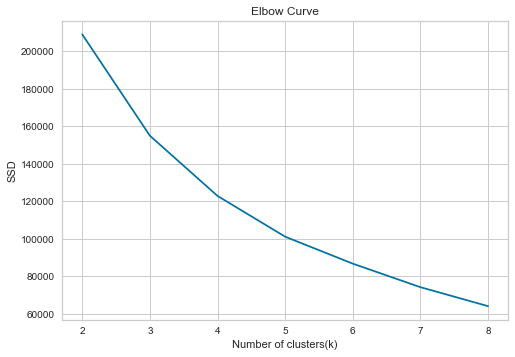

In [10]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

#sse = [] 
#silhouette = []
#labels = []
#listeKMeans = []
listeCentroide = []
#listepredict = []
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,**kmeans_kwargs)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    listeCentroide.append(kmeans.cluster_centers_)
    #silhouette_avg = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')
    #silhouette.append(silhouette_avg)
    
# silhouette score
#silhouette_avg = silhouette_score(X_scaled, cluster_labels)
#print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()

In [11]:

silhouette = []
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

For n_clusters=2, the silhouette score is 0.44
For n_clusters=3, the silhouette score is 0.47
For n_clusters=4, the silhouette score is 0.48
For n_clusters=5, the silhouette score is 0.48
For n_clusters=6, the silhouette score is 0.42
For n_clusters=7, the silhouette score is 0.42
For n_clusters=8, the silhouette score is 0.45


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


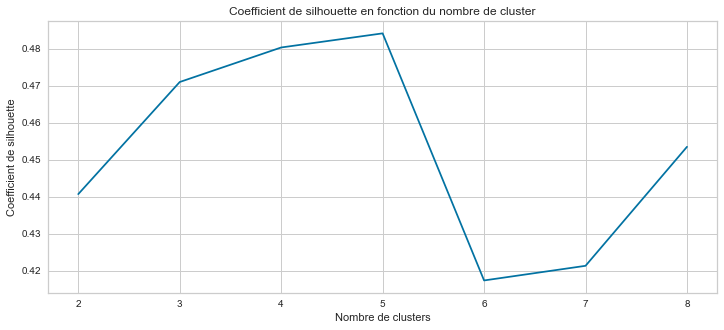

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
#ax = sn.lineplot(n_clusters, silhouette, ax=ax)
ax = sn.lineplot(range_n_clusters, silhouette, ax=ax)
ax.set_title("Coefficient de silhouette en fonction du nombre de cluster")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Coefficient de silhouette")
plt.show()

In [13]:
# fit kmeans with 2 clustes
#kmeans = KMeans(n_clusters=2, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k2 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k2 = rfm.assign(cluster = cluster_labels_k2)


# fit kmeans with 3 clustes
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(X_scaled)
# extract the lables
cluster_labels_k3 = kmeans.labels_
# assing the cluster labels to the dataset
rfm_k3 = data_rfm.assign(cluster = cluster_labels_k3)

# fit kmeans with 4 clustes
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(X_scaled)
# extract the lables
cluster_labels_k4 = kmeans.labels_
# assing the cluster labels to the dataset
rfm_k4 = data_rfm.assign(cluster = cluster_labels_k4)

# fit kmeans with 5 clustes
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(X_scaled)
# extract the lables
cluster_labels_k5 = kmeans.labels_
# assing the cluster labels to the dataset
rfm_k5 = data_rfm.assign(cluster = cluster_labels_k5)

# fit kmeans with 6 clustes
#kmeans = KMeans(n_clusters=6, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k6 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k6 = data_rfm.assign(cluster = cluster_labels_k6)

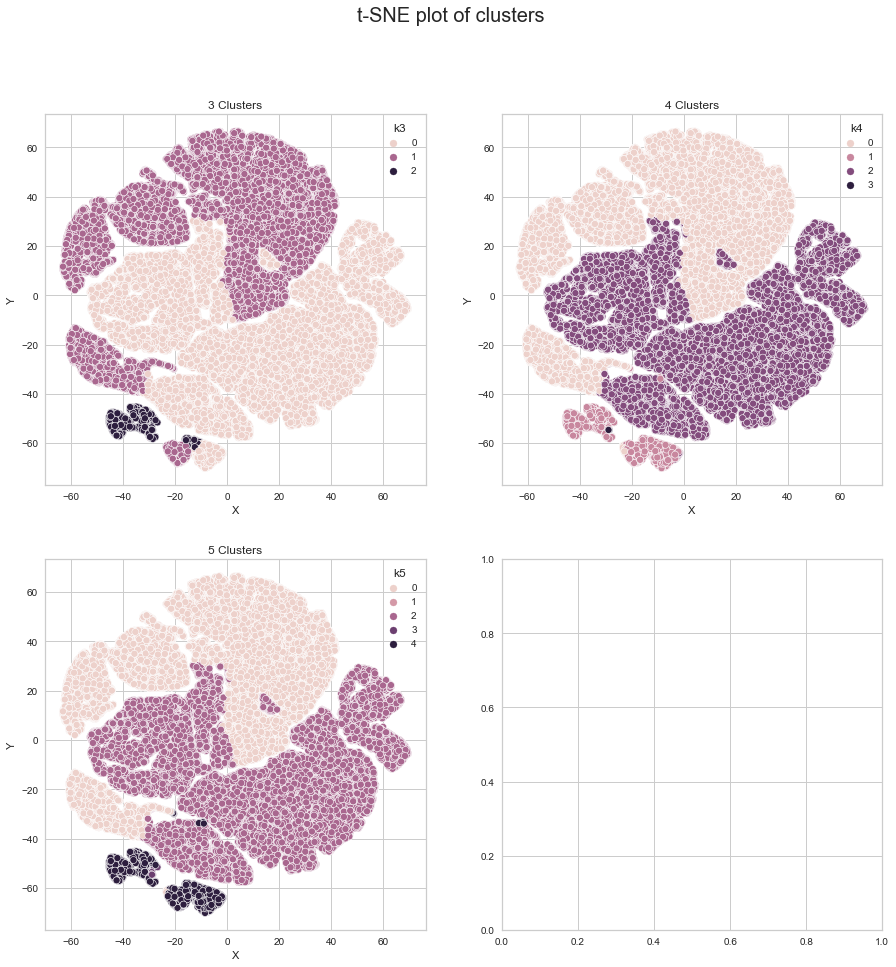

In [14]:
tsne = TSNE(learning_rate=300, perplexity=80, early_exaggeration=20)
#tsne = TSNE(n_components=2,n_jobs=-1)
tsne_array = tsne.fit_transform(X_scaled)
#tsne_data = pd.DataFrame(tsne_array, columns=['x', 'y'], index=df_data.index)
tsne_data = pd.DataFrame(tsne_array, columns=['x', 'y'], index=data_rfm.index)
tsne_data['k3'] = rfm_k3.cluster
tsne_data['k4'] = rfm_k4.cluster
tsne_data['k5'] = rfm_k5.cluster
#tsne_data['k6'] = rfm_k6.cluster
fig, ax = plt.subplots(2,2, figsize=(15,15))
sn.scatterplot(x='x', y='y', hue='k3', data=tsne_data, ax=ax[0,0])
ax[0,0].set_title('3 Clusters')
ax[0,0].set_xlabel('X')
ax[0,0].set_ylabel('Y')

sn.scatterplot(x='x', y='y', hue='k4', data=tsne_data, ax=ax[0,1])
ax[0,1].set_title('4 Clusters')
ax[0,1].set_xlabel('X')
ax[0,1].set_ylabel('Y')

sn.scatterplot(x='x', y='y', hue='k5', data=tsne_data, ax=ax[1,0])
ax[1,0].set_title('5 Clusters')
ax[1,0].set_xlabel('X')
ax[1,0].set_ylabel('Y')

#sn.scatterplot(x='x', y='y', hue='k6', data=tsne_data, ax=ax[1,1])
#ax[1,1].set_title('6 Clusters')
#ax[1,1].set_xlabel('X')
#ax[1,1].set_ylabel('Y')
fig.suptitle('t-SNE plot of clusters', fontsize=20)
# plt.tight_layout()
plt.show()

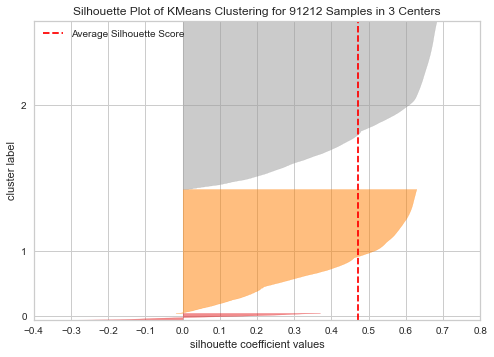

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(KMeans(n_clusters=3,**kmeans_kwargs))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()

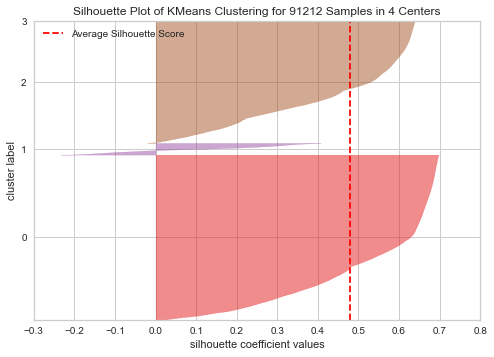

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
# Instantiate the clustering model and visualizer 
#visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=4, n_init=10))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=4,**kmeans_kwargs))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()

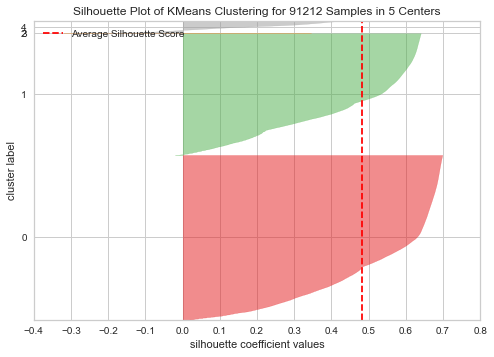

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
# Instantiate the clustering model and visualizer 
#visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=5, n_init=10))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=5,**kmeans_kwargs))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()

In [18]:
#rfm_k3.head()

In [19]:
#rfm_k3.reset_index(inplace = True)
rfm_k4.reset_index(inplace = True)
#rfm_k5.reset_index(inplace = True)
#rfm_k6.reset_index(inplace = True)

In [20]:
rfm_k4.head()

,customer_unique_id,recency,frequency,monetary,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,2
2,0000f46a3911fa3c0805444483337064,537,1,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,0


In [21]:
rfm_k4.describe()

,recency,frequency,monetary,cluster
count,91212.000000,91212.000000,91212.000000,91212.000000
mean,235.832434,1.237315,212.225838,1.145025
std,150.895126,0.844144,631.847668,0.969837
min,1.000000,1.000000,9.590000,0.000000
25%,113.000000,1.000000,63.830000,0.000000
50%,217.000000,1.000000,112.830000,2.000000
75%,344.000000,1.000000,202.652500,2.000000
max,602.000000,75.000000,109312.640000,3.000000


In [22]:
rfm_k4.loc[rfm_k4['cluster'] == 0][:5]


,customer_unique_id,recency,frequency,monetary,cluster
2,0000f46a3911fa3c0805444483337064,537,1,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,0
8,0005e1862207bf6ccc02e4228effd9a0,543,1,150.12,0
10,0006fdc98a402fceb4eb0ee528f6a8d4,408,1,29.00,0


In [23]:
rfm_k4.loc[rfm_k4['cluster'] == 1][:5]

,customer_unique_id,recency,frequency,monetary,cluster
22,000fbf0473c10fc1ab6f8d2d286ce20c,35,4,1449.52,1
152,0064a1b5f5cddd047c987b988a90c8c1,181,4,1076.80,1
196,0085139b503668b3addcfe826d91be8d,212,3,1513.41,1
219,0096c18412349537abc45e350581cbbc,533,4,3080.96,1
224,0097fca0db567f5ca79509b7b4fc1c2d,133,7,1593.41,1


In [24]:
rfm_k4.loc[rfm_k4['cluster'] == 2][:5]

,customer_unique_id,recency,frequency,monetary,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,2
5,0004bd2a26a76fe21f786e4fbd80607f,146,1,166.98,2
6,00050ab1314c0e55a6ca13cf7181fecf,132,1,35.38,2
7,00053a61a98854899e70ed204dd4bafe,183,2,838.36,2


In [25]:
rfm_k4.loc[rfm_k4['cluster'] == 3][:5]

,customer_unique_id,recency,frequency,monetary,cluster
3648,0a0a92112bd4c708ca5fde585afaa872,334,8,109312.64,3
5511,0f5ac8d5c31de21d2f25e24be15bbffb,276,18,19342.26,3
6474,11f97da02237a49c8e783dfda6f50e8e,576,15,11745.00,3
9866,1b76903617af13189607a36b0469f6f3,100,6,19174.38,3
11697,20a5257c01689ac69410a14cb51bb447,352,10,17671.00,3


In [26]:
#etiquetter client par segment
segments = {3:'platinum', 0:'silver',1:'gold',2:'bronze'}
rfm_k4['segment'] = rfm_k4['cluster'].map(segments)
rfm_k4.head()

,customer_unique_id,recency,frequency,monetary,cluster,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,2,bronze
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,2,bronze
2,0000f46a3911fa3c0805444483337064,537,1,86.22,0,silver
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,0,silver
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,0,silver


In [27]:
nb_cluster_rfmk4 = rfm_k4['cluster'].value_counts().to_frame()
nb_cluster_rfmk4.style.background_gradient(cmap='Reds')

,cluster
2,50403
0,37219
1,3568
3,22


In [28]:
nb_cluster_rfmk4_bis = rfm_k4['cluster'].value_counts()

<AxesSubplot:ylabel='cluster'>

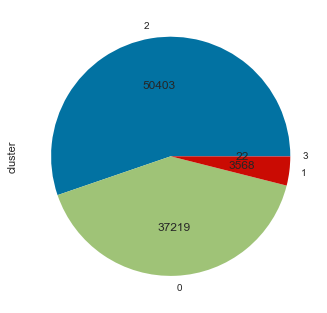

In [29]:
nb_cluster_rfmk4_bis.plot.pie(autopct=lambda x: '{:.0f}'.format(x*nb_cluster_rfmk4_bis.sum()/100) )

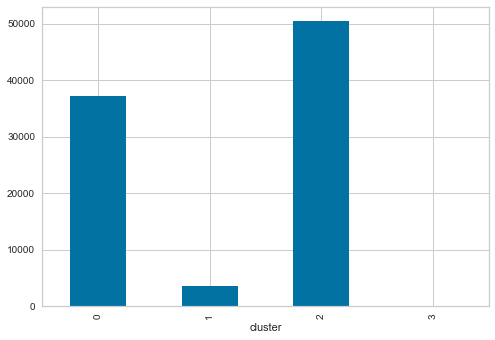

In [30]:
nb_cluster_rfmk4_bis = rfm_k4.groupby(['cluster']).count()['customer_unique_id'].plot(kind='bar')

In [31]:
#plt.pie(rfm_k3.groupby(['cluster']).count()['customer_unique_id'],startangle=90,autopct='%1.0f%%',labels=['cluster 0.0','cluster 1.0','cluster 2.0'])
#plt.legend(loc="upper right",bbox_to_anchor=(1.255, 1.15))


In [32]:
#plt.pie(rfm_k4.groupby(['cluster']).count()['customer_unique_id'],startangle=90,autopct='%1.0f%%',labels=['cluster 0.0','cluster 1.0','cluster 2.0','cluster 3.0'])
#plt.legend(loc="upper right",bbox_to_anchor=(1.255, 1.15))


In [33]:
#plt.pie(rfm_k5.groupby(['cluster']).count()['customer_unique_id'],startangle=90,autopct='%1.0f%%',labels=['cluster 0.0','cluster 1.0','cluster 2.0','cluster 3.0','cluster 4.0'])
#plt.legend(loc="upper right",bbox_to_anchor=(1.255, 1.15))



In [34]:
#Melt dataframe that have been created
rfm_melted = pd.melt(frame = rfm_k4, id_vars = ['customer_unique_id','segment'], 
                     var_name = 'variable', value_name = 'value')

#Display melted dataframe
rfm_melted.head()

,customer_unique_id,segment,variable,value
0,0000366f3b9a7992bf8c76cfdf3221e2,bronze,recency,112.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,bronze,recency,115.0
2,0000f46a3911fa3c0805444483337064,silver,recency,537.0
3,0000f6ccb0745a6a4b88665a16c9f078,silver,recency,321.0
4,0004aac84e0df4da2b147fca70cf8255,silver,recency,288.0


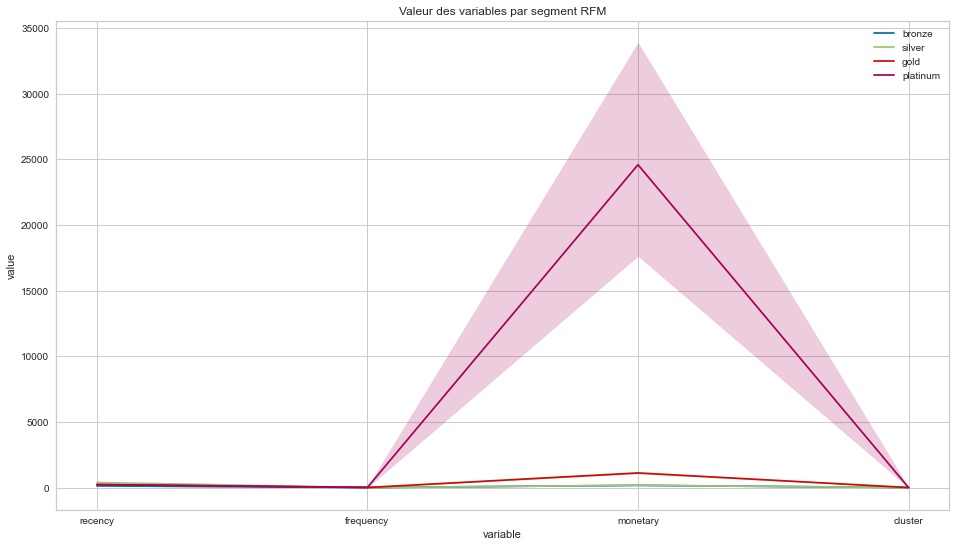

In [35]:
#Visualize snake plot
fig, ax = plt.subplots(figsize = (16, 9))
sn.lineplot(x = 'variable', y = 'value', hue = 'segment', data = rfm_melted)

#Set title and legend
plt.title('Valeur des variables par segment RFM')
plt.legend(loc = 'upper right')

# essaie 2 RFM : recency/frequency/monetary/score

In [36]:
data_rfm_score = df_data[['recency','frequency','monetary','average_review_score']]

#préparation des données pour le clustering (CAH ou k-means)ici, j'ai décidé de faire avec la méthode K-means car 
#après avoir testé les deux méthodes, K-means a pu obtenu un résutat plus fin #
X = data_rfm_score.values
names = data_rfm_score.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

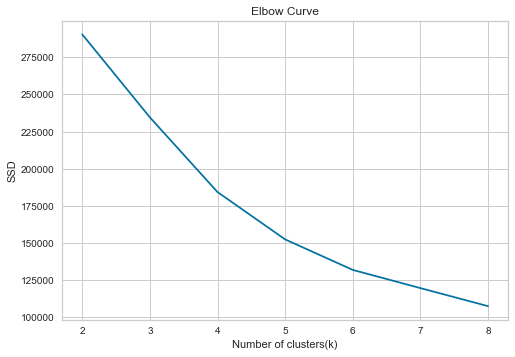

In [37]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

#sse = [] 
#silhouette = []
#labels = []
#listeKMeans = []
listeCentroide = []
#listepredict = []
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,**kmeans_kwargs)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    listeCentroide.append(kmeans.cluster_centers_)
    #silhouette_avg = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')
    #silhouette.append(silhouette_avg)
    
# silhouette score
#silhouette_avg = silhouette_score(X_scaled, cluster_labels)
#print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()

In [38]:

silhouette = []
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, **kmeans_kwargs)
    kmeans.fit(X_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

For n_clusters=2, the silhouette score is 0.43
For n_clusters=3, the silhouette score is 0.38
For n_clusters=4, the silhouette score is 0.4
For n_clusters=5, the silhouette score is 0.4
For n_clusters=6, the silhouette score is 0.41
For n_clusters=7, the silhouette score is 0.33
For n_clusters=8, the silhouette score is 0.34


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


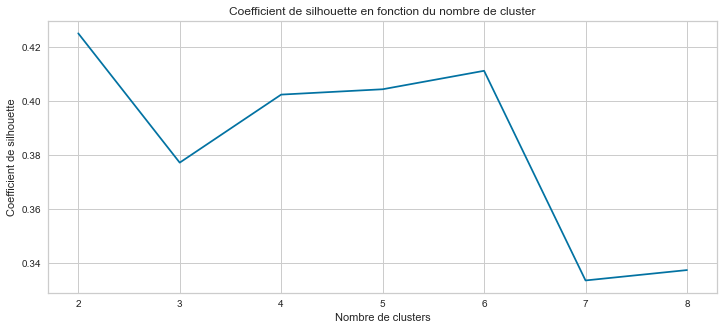

In [39]:
fig, ax = plt.subplots(figsize=(12,5))
#ax = sn.lineplot(n_clusters, silhouette, ax=ax)
ax = sn.lineplot(range_n_clusters, silhouette, ax=ax)
ax.set_title("Coefficient de silhouette en fonction du nombre de cluster")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Coefficient de silhouette")
plt.show()

In [40]:
# fit kmeans with 2 clustes
#kmeans = KMeans(n_clusters=2, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k2 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k2 = data_rfm_score.assign(cluster = cluster_labels_k2)


# fit kmeans with 3 clustes
#kmeans = KMeans(n_clusters=3, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k3 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k3 = data.assign(cluster = cluster_labels_k3)
# fit kmeans with 4 clustes
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(X_scaled)
# extract the lables
cluster_labels_k4 = kmeans.labels_
# assing the cluster labels to the dataset
rfm_score_k4 = data_rfm_score.assign(cluster = cluster_labels_k4)

# fit kmeans with 5 clustes
#kmeans = KMeans(n_clusters=5, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k5 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_score_k5 = data_rfm_score.assign(cluster = cluster_labels_k5)


# fit kmeans with 6 clustes
kmeans = KMeans(n_clusters=6, **kmeans_kwargs)
kmeans.fit(X_scaled)
# extract the lables
cluster_labels_k6 = kmeans.labels_
# assing the cluster labels to the dataset
rfm_score_k6 = data_rfm_score.assign(cluster = cluster_labels_k6)

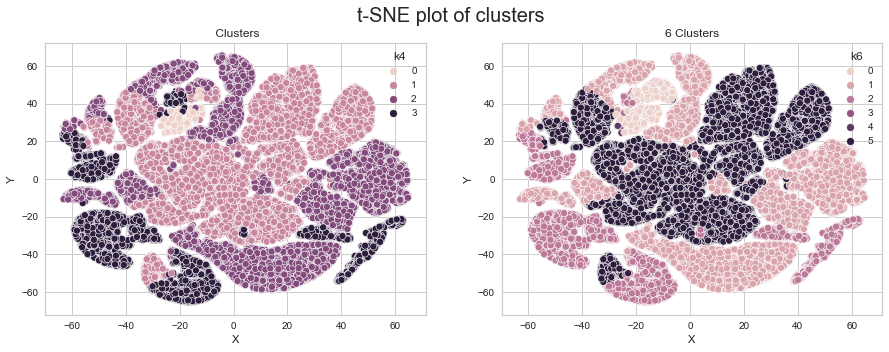

In [41]:
tsne = TSNE(learning_rate=300, perplexity=80, early_exaggeration=20)
#tsne = TSNE(n_components=2,n_jobs=-1)
tsne_array = tsne.fit_transform(X_scaled)
tsne_data = pd.DataFrame(tsne_array, columns=['x', 'y'], index=data_rfm_score.index)
tsne_data['k4'] = rfm_score_k4.cluster
#tsne_data['k5'] = rfm_score_k5.cluster
tsne_data['k6'] = rfm_score_k6.cluster
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sn.scatterplot(x='x', y='y', hue='k4', data=tsne_data, ax=ax[0])
ax[0].set_title(' Clusters')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
sn.scatterplot(x='x', y='y', hue='k6', data=tsne_data, ax=ax[1])
ax[1].set_title('6 Clusters')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
#sn.scatterplot(x='x', y='y', hue='k6', data=tsne_data, ax=ax[2])
#ax[2].set_title('6 Clusters')
#ax[2].set_xlabel('X')
#ax[2].set_ylabel('Y')
fig.suptitle('t-SNE plot of clusters', fontsize=20)
# plt.tight_layout()
plt.show()

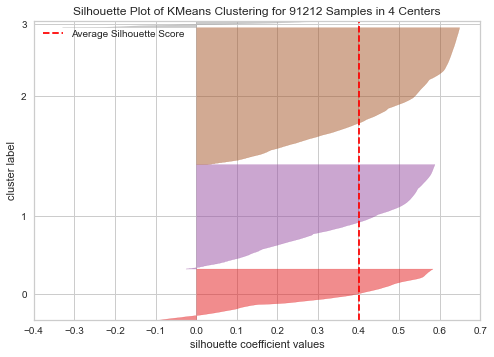

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [42]:
# Instantiate the clustering model and visualizer 
#visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=4, n_init=10))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=4, **kmeans_kwargs))
visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()

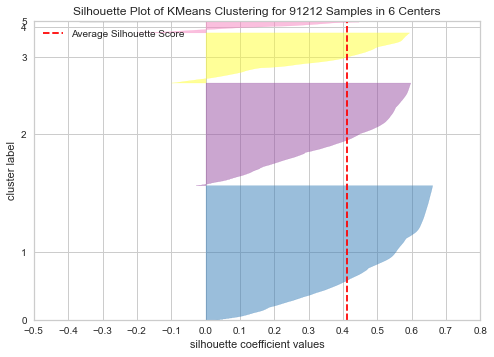

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 91212 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
# Instantiate the clustering model and visualizer 
#visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=6, n_init=10))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=6, **kmeans_kwargs))
visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()

In [44]:
rfm_score_k4.reset_index(inplace = True)
#rfm_score_k5.reset_index(inplace = True)
rfm_score_k6.reset_index(inplace = True)

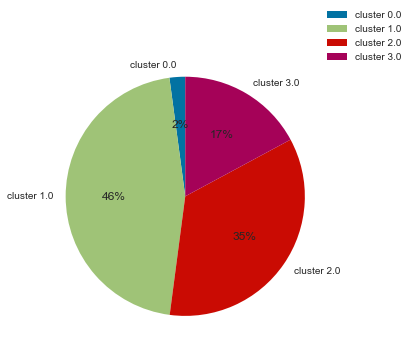

In [45]:
plt.pie(rfm_score_k4.groupby(['cluster']).count()['customer_unique_id'],startangle=90,autopct='%1.0f%%',labels=['cluster 0.0','cluster 1.0','cluster 2.0','cluster 3.0'])
plt.legend(loc="upper right",bbox_to_anchor=(1.255, 1.15))



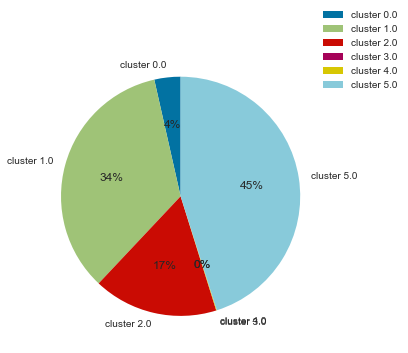

In [46]:
plt.pie(rfm_score_k6.groupby(['cluster']).count()['customer_unique_id'],startangle=90,autopct='%1.0f%%',labels=['cluster 0.0','cluster 1.0','cluster 2.0','cluster 3.0','cluster 4.0','cluster 5.0'])
plt.legend(loc="upper right",bbox_to_anchor=(1.255, 1.15))



In [47]:
nb_individu_par_cluster_rfmscore_k4=rfm_score_k4[['cluster','customer_unique_id']].groupby('cluster').count()


In [48]:
nb_individu_par_cluster_rfmscore_k6=rfm_score_k6[['cluster','customer_unique_id']].groupby('cluster').count()

In [49]:
nb_individu_par_cluster_rfmscore_k4

,customer_unique_id
cluster,
0,1931
1,41781
2,31865
3,15635


In [50]:
nb_individu_par_cluster_rfmscore_k6

,customer_unique_id
cluster,
0,3224
1,31421
2,15354
3,1
4,80
5,41132


# essaie ACP : recency/frequency/monetary/
# montant moyen/montant minimum/montant maximum/
# nb cde /nb produit/nb_payment

In [51]:
data_ACP_rfm = df_data[['recency','frequency','monetary','average_purchase','min_purchase','max_purchase','nb_cde_per_customer','nb_item_per_customer','nb_payment']]



In [52]:
#préparation des données pour le clustering (CAH ou k-means)ici, j'ai décidé de faire avec la méthode K-means car 
#après avoir testé les deux méthodes, K-means a pu obtenu un résutat plus fin #
X = data_ACP_rfm.values
names = data_ACP_rfm.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [53]:
pca = PCA()
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([3.69444116e-01, 3.51542262e-01, 1.12441740e-01, 9.41161654e-02,
       7.07334739e-02, 1.68987955e-03, 3.23633828e-05, 3.84131243e-33,
       9.39586280e-44])

Text(0, 0.5, 'Variance expliqué cumulative')

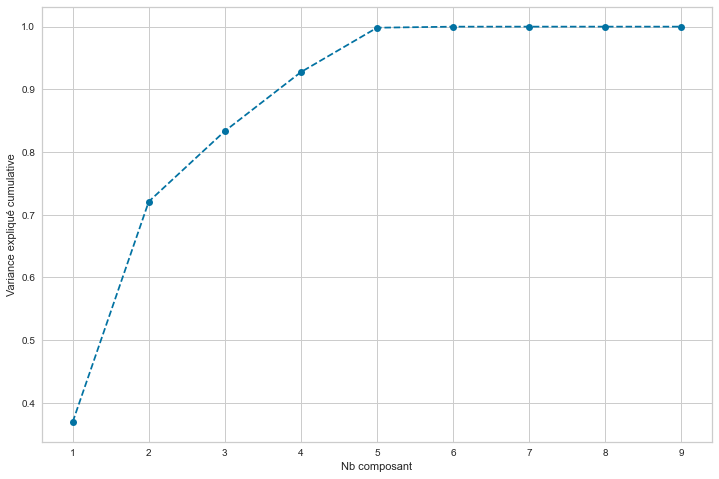

In [54]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Nb composant')
plt.ylabel('Variance expliqué cumulative')

In [55]:
pca_ACP_rfm = PCA(n_components=4)
principalComponents_ACP_rfm = pca_ACP_rfm.fit_transform(X_scaled)

#pca = PCA(n_components=4)
#pca.fit(X_scaled)



In [56]:
n_comp =4
features = data_ACP_rfm.columns

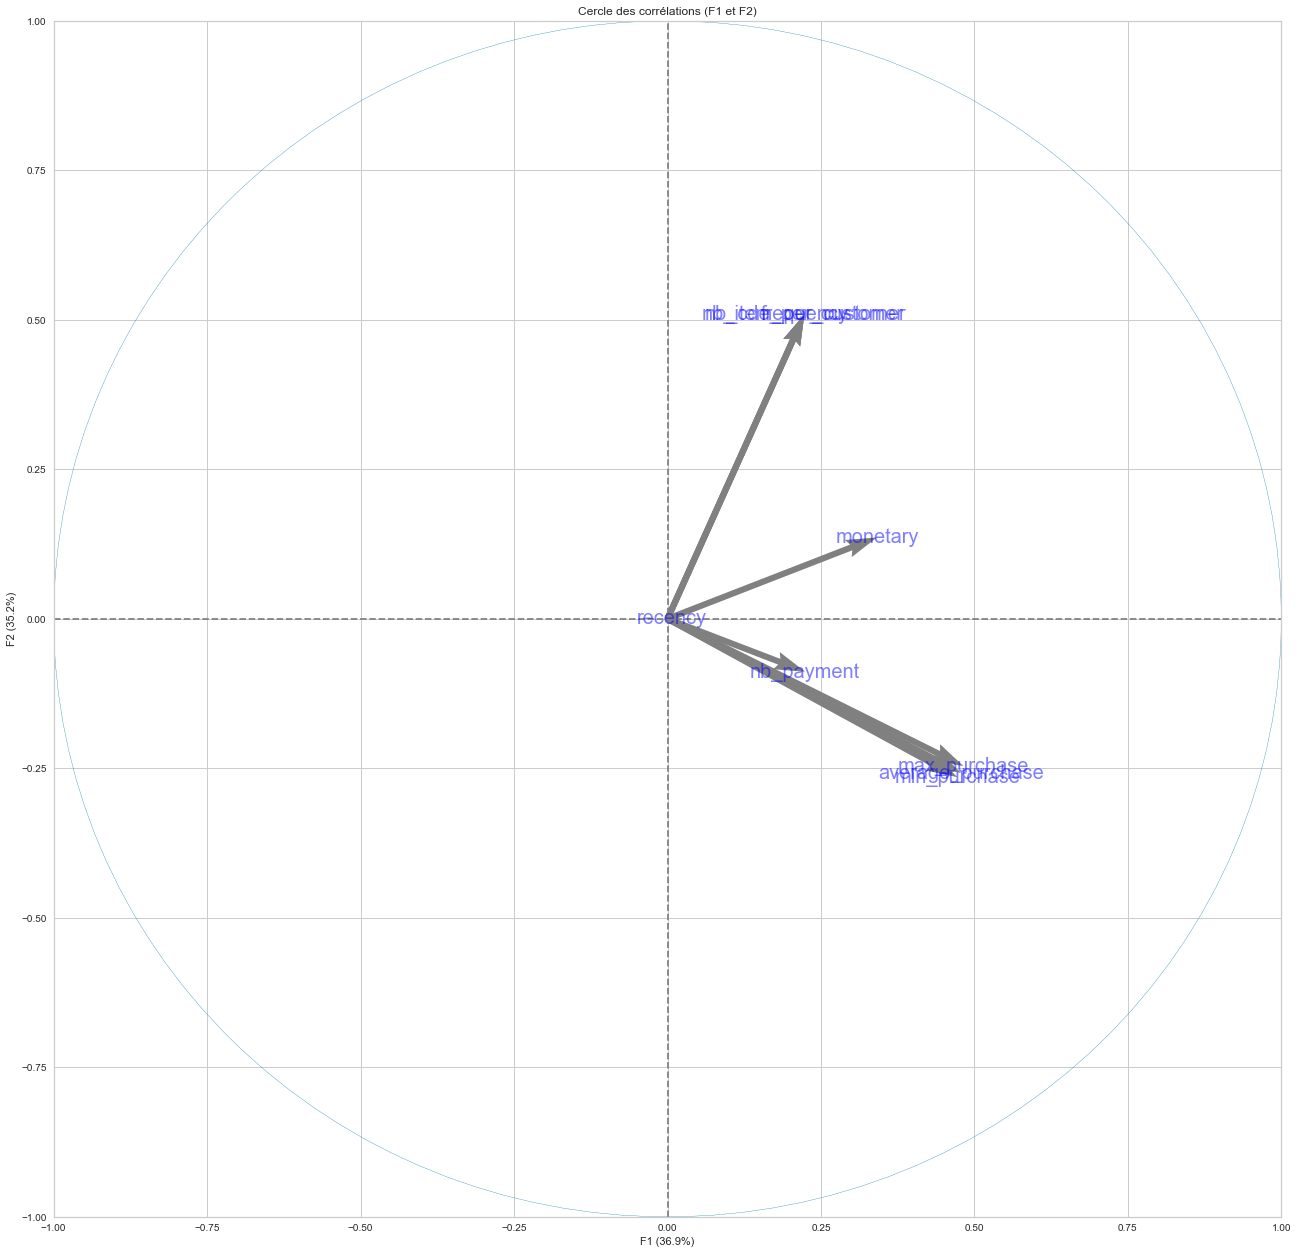

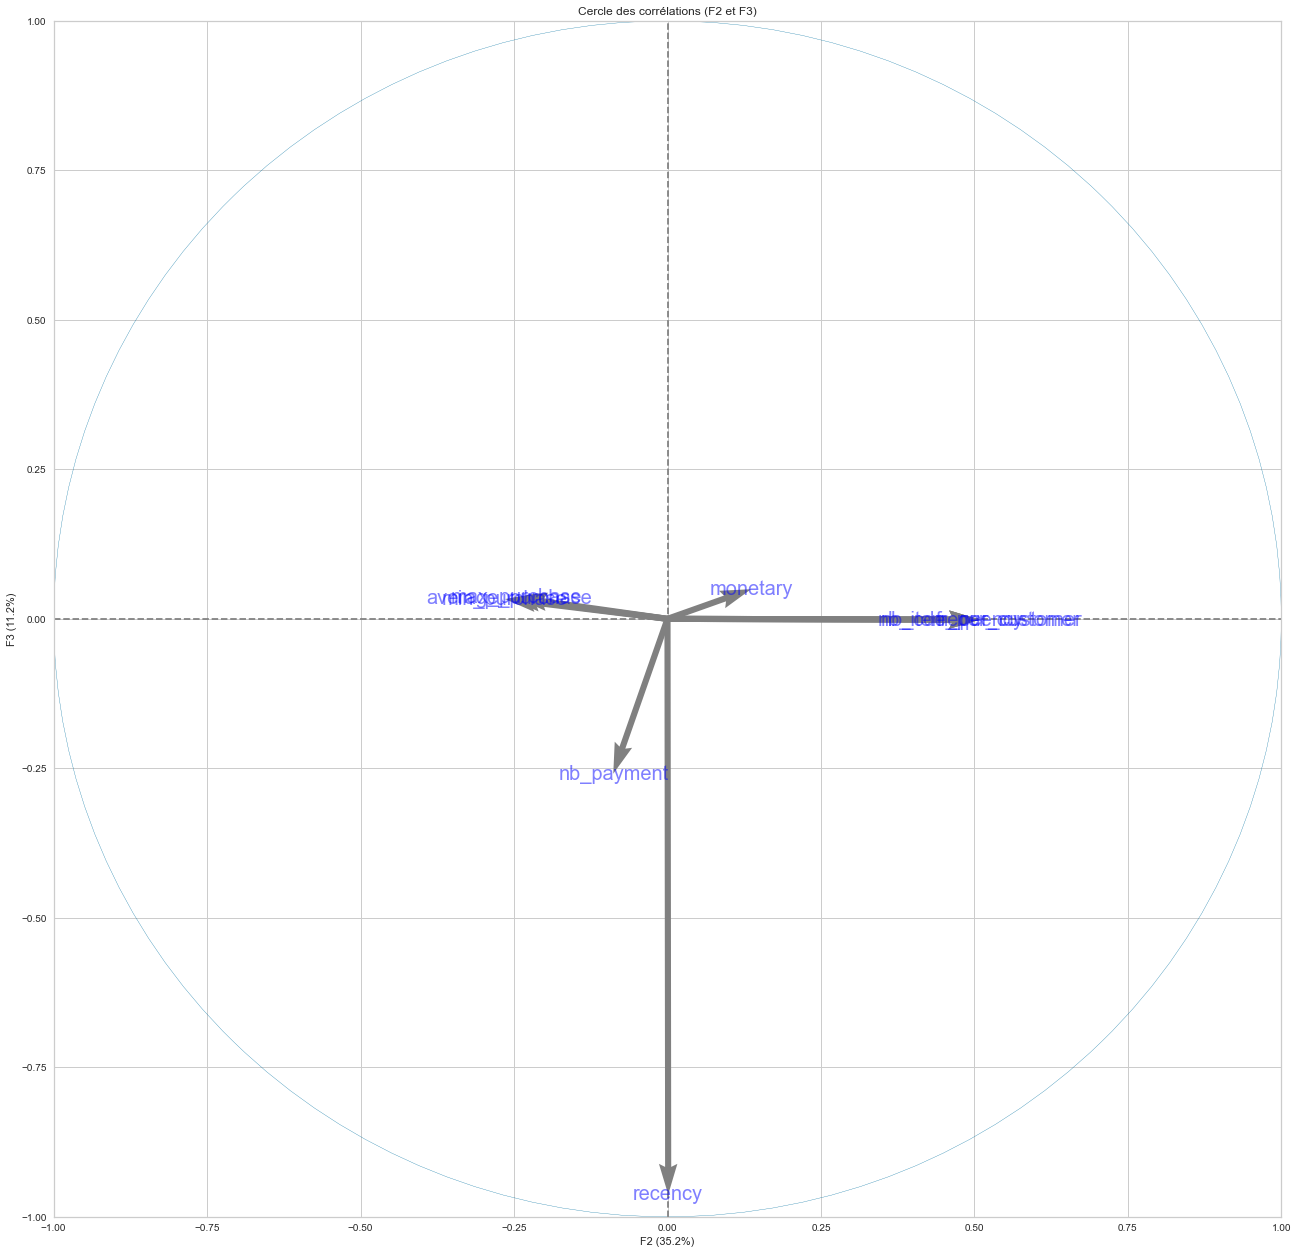

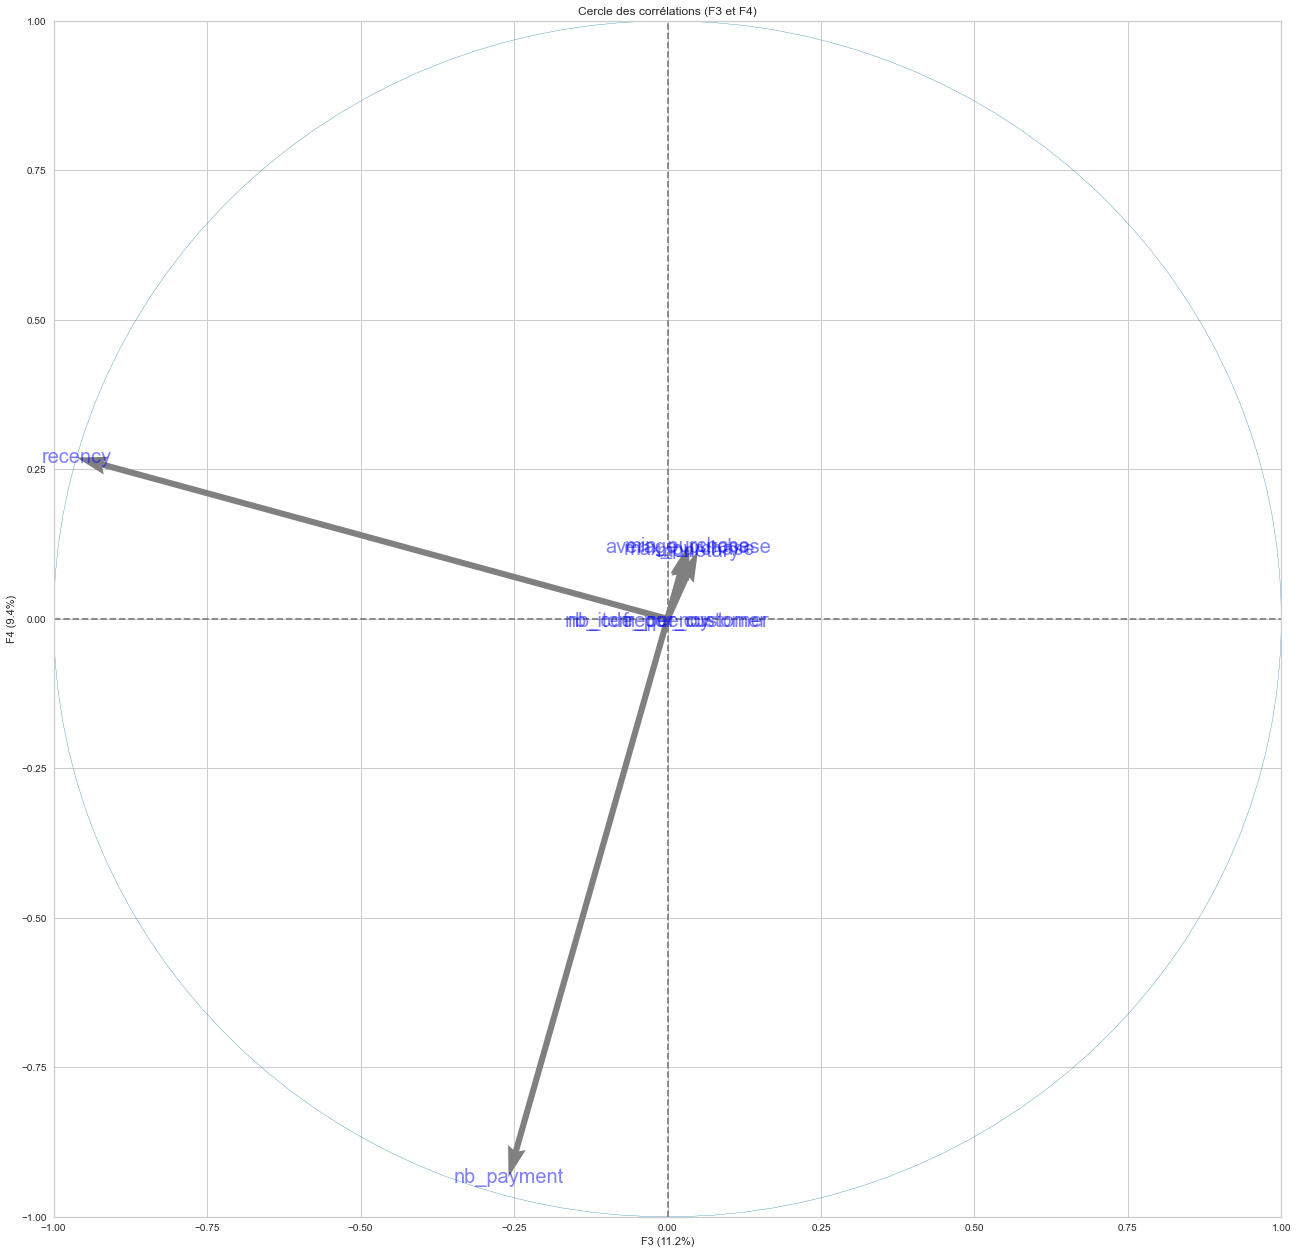

In [57]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(1,2),(2,3)], labels = np.array(features))

#### F1 = dépense
#### F2 = commande/produit 
#### F3 = nb_payment
#### F4 = récence

In [58]:
df_pca_components = pd.DataFrame(data = principalComponents_ACP_rfm,index = data_ACP_rfm.index, columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4'])

df_pca_components.head()

,principal component 1,principal component 2,principal component 3,principal component 4
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.226485,-0.630636,0.295005,-1.999502
0000b849f77a49e4a4ce2b2a4ca5be3f,-1.261539,0.026568,0.883383,0.214337
0000f46a3911fa3c0805444483337064,-0.243942,-0.391991,-2.454162,-1.365207
0000f6ccb0745a6a4b88665a16c9f078,-0.937867,-0.096103,-0.715935,-0.446534
0004aac84e0df4da2b147fca70cf8255,0.476632,-0.755056,-0.602968,-0.882917


In [59]:
df_pca_components.shape

(91212, 4)

In [61]:
df_pca_components.to_csv("data_ACP.csv", index=False)

In [ ]:

df_pca_components.reset_index(inplace = True)

In [ ]:

X_bis = df_pca_components.copy()
X_bis = X_bis.drop(['customer_unique_id'], axis = 1)

In [ ]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

#sse = [] 
#silhouette = []
#labels = []
#listeKMeans = []
listeCentroide = []
#listepredict = []
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,**kmeans_kwargs)
    kmeans.fit(X_bis)
    ssd.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    listeCentroide.append(kmeans.cluster_centers_)
    #silhouette_avg = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')
    #silhouette.append(silhouette_avg)
    
# silhouette score
#silhouette_avg = silhouette_score(X_scaled, cluster_labels)
#print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()

In [ ]:
silhouette = []
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, **kmeans_kwargs)
    kmeans.fit(X_bis)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_bis, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
#ax = sn.lineplot(n_clusters, silhouette, ax=ax)
ax = sn.lineplot(range_n_clusters, silhouette, ax=ax)
ax.set_title("Coefficient de silhouette en fonction du nombre de cluster")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Coefficient de silhouette")
plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=(12,5))
#ax = sn.lineplot(n_clusters, silhouette, ax=ax)
#ax.set_title("Coefficient de silhouette en fonction du nombre de cluster")
#ax.set_xlabel("Nombre de clusters")
#ax.set_ylabel("Coefficient de silhouette")
#plt.show()

In [ ]:
# fit kmeans with 2 clustes
#kmeans = KMeans(n_clusters=2, random_state=1)
#kmeans.fit(X_bis)
# extract the lables
#cluster_labels_k2 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k2 = data_ACP_rfm_bis.assign(cluster = cluster_labels_k2)


# fit kmeans with 3 clustes
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(X_bis)
# extract the lables
cluster_labels_k3 = kmeans.labels_
# assing the cluster labels to the dataset
acp_k3 = df_pca_components.assign(cluster = cluster_labels_k3)
# fit kmeans with 5 clustes
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(X_bis)
# extract the lables
cluster_labels_k5 = kmeans.labels_
# assing the cluster labels to the dataset
acp_k5 = df_pca_components.assign(cluster = cluster_labels_k5)
# fit kmeans with 5 clustes
#kmeans = KMeans(n_clusters=5, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k5 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k5 = data_2.assign(cluster = cluster_labels_k5)


# fit kmeans with 6 clustes
#kmeans = KMeans(n_clusters=6, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k6 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k6 = data_2.assign(cluster = cluster_labels_k6)

In [ ]:
tsne = TSNE(learning_rate=300, perplexity=80, early_exaggeration=20)
#tsne = TSNE(n_components=2)
tsne_array = tsne.fit_transform(X_bis)
tsne_data = pd.DataFrame(tsne_array, columns=['x', 'y'], index=df_pca_components.index)
#tsne_data['k2'] = rfm_k2.cluster
tsne_data['k3'] = acp_k3.cluster
tsne_data['k5'] = acp_k5.cluster
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sn.scatterplot(x='x', y='y', hue='k3', data=tsne_data, ax=ax[0])
ax[0].set_title('3 Clusters')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
sn.scatterplot(x='x', y='y', hue='k5', data=tsne_data, ax=ax[1])
ax[1].set_title('5 Clusters')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
#sn.scatterplot(x='x', y='y', hue='k6', data=tsne_data, ax=ax[2])
#ax[2].set_title('6 Clusters')
#ax[2].set_xlabel('X')
#ax[2].set_ylabel('Y')
fig.suptitle('t-SNE plot of clusters', fontsize=20)
# plt.tight_layout()
plt.show()

In [ ]:
# Instantiate the clustering model and visualizer 
#visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=3, n_init=10))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=3,**kmeans_kwargs))
visualizer.fit(X_bis)    # Fit the data to the visualizer
visualizer.show()

In [ ]:
# Instantiate the clustering model and visualizer 
#visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=5, n_init=10))
#visualizer = SilhouetteVisualizer(KMeans(n_clusters=5,**kmeans_kwargs))
#visualizer.fit(X_bis)    # Fit the data to the visualizer
#visualizer.show()

In [ ]:
acp_k3.reset_index(inplace = True)
#acp_k5.reset_index(inplace = True)

In [ ]:
acp_k3.head()

In [ ]:
#etiquetter client par segment
segments = {0:'client perdu',1:'client potentiel',2:'client fidèle'}
acp_k3['segment'] = acp_k3['cluster'].map(segments)
acp_k3.head()

In [ ]:
nb_cluster_acpk3 = acp_k3['cluster'].value_counts().to_frame()
nb_cluster_acpk3.style.background_gradient(cmap='Reds')

In [ ]:
nb_cluster_acpk3_bis = acp_k3['cluster'].value_counts()

In [ ]:
nb_cluster_acpk3_bis.plot.pie(autopct=lambda x: '{:.0f}'.format(x*nb_cluster_acpk3_bis.sum()/100) )


In [ ]:
nb_cluster_acpk3_bis = acp_k3.groupby(['cluster']).count()['customer_unique_id'].plot(kind='bar')

In [ ]:
#plt.pie(acp_k5.groupby(['cluster']).count()['customer_unique_id'],startangle=90,autopct='%1.0f%%',labels=['cluster 0.0','cluster 1.0','cluster 2.0','cluster 3.0','cluster 4.0'])
#plt.legend(loc="upper right",bbox_to_anchor=(1.255, 1.15))

In [ ]:
acp_k3 = acp_k3.drop('index', axis = 1)


In [ ]:
acp_k3.head()

In [ ]:
#Melt dataframe that have been created
acp_melted = pd.melt(frame = acp_k3, id_vars = ['customer_unique_id','segment'], 
                     var_name = 'variable', value_name = 'value')

#Display melted dataframe
acp_melted.head()

In [ ]:
#Visualize snake plot
fig, ax = plt.subplots(figsize = (16, 9))
sn.lineplot(x = 'variable', y = 'value', hue = 'segment', data = acp_melted)

#Set title and legend
plt.title('Valeur des variables par segment ACP')
plt.legend(loc = 'upper right')

- Cluster 0: sont des clients qui ne dépensent pas beaucoup et qui ne receivennt pas souvent 
- Cluster 1: sont des clients qui dépensent le plus , qui achètent le moins produit , au niveau du nb_payment et 
  récence c'est moyen
- Cluster 2: sont des clients qui dépensent moyennment, qui achètent le plus de produit, au niveau du nb_payment et   récence c'est moyen

#### PC1 = dépense
#### PC2 = commande/produit 
#### PC3 = nb_payment
#### PC4 = récence

# essaie ACP +variable catégorielle

In [ ]:
df_data = df_data.drop(['payment_type','customer_city','customer_state','deadline_order'], axis = 1)

In [ ]:
X = df_data.copy()
#X = df_data.drop(columns=['customer_unique_id']) 
X = X.reset_index(drop=True)

categorical_columns = X.select_dtypes('object').columns
#numerical_columns = X.drop(columns=categorical_columns).columns

#scaler = StandardScaler()
#X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

encoder = OneHotEncoder(sparse=False)
X_categorical = encoder.fit_transform(X[categorical_columns])

#binariser les variables categorielles  (binariser ma target)
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(X[categorical_columns])



#création dataframe pour les variables binarisées 
df_temp = pd.DataFrame(columns = ohe.get_feature_names(), data=ohe.fit_transform(X[categorical_columns]))
df_temp.reset_index(drop=True)


#création dataframe variables catégorielles binarisées + variables quantitatives standardisés
X_cat_acp= pd.merge(df_pca_components,df_temp, left_index=True, right_index=True)

In [ ]:
X_cat_acp.head()

In [ ]:
X_cat_acp_bis = X_cat_acp.copy()
X_cat_acp_bis = X_cat_acp_bis.drop(['customer_unique_id'], axis = 1)


In [ ]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

#sse = [] 
#silhouette = []
#labels = []
#listeKMeans = []
listeCentroide = []
#listepredict = []
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,**kmeans_kwargs)
    kmeans.fit(X_cat_acp_bis)
    ssd.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    listeCentroide.append(kmeans.cluster_centers_)
    #silhouette_avg = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')
    #silhouette.append(silhouette_avg)
    
# silhouette score
#silhouette_avg = silhouette_score(X_scaled, cluster_labels)
#print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()

In [ ]:
silhouette = []
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, **kmeans_kwargs)
    kmeans.fit(X_cat_acp_bis)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_cat_acp_bis, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
#ax = sn.lineplot(n_clusters, silhouette, ax=ax)
ax = sn.lineplot(range_n_clusters, silhouette, ax=ax)
ax.set_title("Coefficient de silhouette en fonction du nombre de cluster")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Coefficient de silhouette")
plt.show()

In [ ]:
# fit kmeans with 3 clustes
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(X_cat_acp_bis)
# extract the lables
cluster_labels_k3 = kmeans.labels_
# assing the cluster labels to the dataset
cat_acp_k3 = X_cat_acp.assign(cluster = cluster_labels_k3)


# fit kmeans with 5 clustes
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(X_cat_acp_bis)
# extract the lables
cluster_labels_k5 = kmeans.labels_
# assing the cluster labels to the dataset
cat_acp_k5 = X_cat_acp.assign(cluster = cluster_labels_k5)
# fit kmeans with 4 clustes
#kmeans = KMeans(n_clusters=4, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k4 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k4 = data.assign(cluster = cluster_labels_k4)
# fit kmeans with 5 clustes
#kmeans = KMeans(n_clusters=5, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k5 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k5 = data_2.assign(cluster = cluster_labels_k5)


# fit kmeans with 6 clustes
#kmeans = KMeans(n_clusters=6, random_state=1)
#kmeans.fit(X_scaled)
# extract the lables
#cluster_labels_k6 = kmeans.labels_
# assing the cluster labels to the dataset
#rfm_k6 = data_2.assign(cluster = cluster_labels_k6)

In [ ]:
tsne = TSNE(learning_rate=300, perplexity=80, early_exaggeration=20)
#tsne = TSNE(n_components=2)
tsne_array = tsne.fit_transform(X_cat_acp_bis)
tsne_data = pd.DataFrame(tsne_array, columns=['x', 'y'], index=X_cat_acp.index)
tsne_data['k3'] = cat_acp_k3.cluster
tsne_data['k5'] = cat_acp_k5.cluster
#tsne_data['k6'] = rfm_k6.cluster
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sn.scatterplot(x='x', y='y', hue='k3', data=tsne_data, ax=ax[0])
ax[0].set_title('3 Clusters')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
sn.scatterplot(x='x', y='y', hue='k5', data=tsne_data, ax=ax[1])
ax[1].set_title('5 Clusters')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
#sn.scatterplot(x='x', y='y', hue='k6', data=tsne_data, ax=ax[2])
#ax[2].set_title('6 Clusters')
#ax[2].set_xlabel('X')
#ax[2].set_ylabel('Y')
fig.suptitle('t-SNE plot of clusters', fontsize=20)
# plt.tight_layout()
plt.show()

In [ ]:
# Instantiate the clustering model and visualizer 
#visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=3, n_init=10))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=3,**kmeans_kwargs))
visualizer.fit(X_cat_acp_bis)    # Fit the data to the visualizer
visualizer.show()

In [ ]:
cat_acp_k3.reset_index(inplace = True)
#rfm_k4.reset_index(inplace = True)

In [ ]:
plt.pie(cat_acp_k3.groupby(['cluster']).count()['customer_unique_id'],startangle=90,autopct='%1.0f%%',labels=['cluster 0.0','cluster 1.0','cluster 2.0'])
plt.legend(loc="upper right",bbox_to_anchor=(1.255, 1.15))

# Modélisation CAH 
# (Classification ascendante hiérarchique )
# (Hierarchical clustering)

In [ ]:
X_sample = df_pca_components.copy()
X_sample = X_sample.sample(n=36586)
X_sample.name = "X_sample"
X_sample.shape

In [ ]:
display(X_sample.duplicated().sum().sum())
display(X_sample.isna().sum().sum())

In [ ]:
df_pca_components.shape

In [ ]:
X_sample = X_sample.drop(['customer_unique_id'], axis = 1)

In [ ]:
#names = df_pca_components.index
#color = 4

In [ ]:
#Z = linkage(X_sample, 'ward')

In [ ]:
# Affichage du dendrogramme
#plot_dendrogram(Z)

In [ ]:
plt.figure(1, figsize = (16 ,8))
dendrogram = sch.dendrogram(sch.linkage(X_sample, method  = "ward"))

plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:

# définir le modèle
model = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat = model.fit(X_sample)
yhat_2 = model.fit_predict(X_sample)
# retrieve unique clusters
clusters = unique(yhat)

In [ ]:
# Calculer cluster validation metrics
score_AGclustering_s = silhouette_score(X_sample, yhat.labels_, metric='euclidean')
print('Silhouette Score: %.4f' % score_AGclustering_s)

In [ ]:
y_hc = hc.fit_predict(df)
y_hc

df['cluster'] = pd.DataFrame(y_hc)

In [ ]:


df_temp = df_pca_components.copy()
df_temp['cluster'] = pd.DataFrame(yhat_2)
df_temp.head()

In [ ]:
nb_individu_par_cluster_cah=df_temp[['cluster','customer_unique_id']].groupby('cluster').count()
nb_individu_par_cluster_cah

# Modélisation DBSCAN 

In [ ]:
X_sample_dbcan = df_pca_components.copy()
X_sample_dbcan = X_sample_dbcan.sample(n=36586)
X_sample_dbcan.name = "X_sample"
X_sample_dbcan.shape

In [ ]:
df_pca_components.head()

In [ ]:
display(X_sample_dbcan.duplicated().sum().sum())
display(X_sample_dbcan.isna().sum().sum())

In [ ]:
X_sample_dbcan.head()

In [ ]:
X_sample_dbcan = X_sample_dbcan.drop(['customer_unique_id'], axis = 1)

In [ ]:
epsilon = 10
minimumSamples = 100
dbscan = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X_sample_dbcan)

labels = dbscan.labels_

In [ ]:
print("Silhouette Coefficient: %0.4f" % metrics.silhouette_score(X_sample_dbcan, labels))

In [ ]:
df_temp = df_pca_components.copy()
df_temp['cluster'] = pd.DataFrame(labels)
df_temp.head()

In [ ]:
nb_individu_par_cluster_dbcan=df_temp[['cluster','customer_unique_id']].groupby('cluster').count()
nb_individu_par_cluster_dbcan